<a href="https://colab.research.google.com/github/jneey2000/ML/blob/main/9_using_convnets_with_small_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
keras.__version__

'3.8.0'

구글드라이브에 데이터를 업로드 후 Colab에 마운트를 해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


kaggle_original_data.zip 파일을 압축해제하고 불러옵니다.

In [ ]:
import zipfile

zipfile.ZipFile('/content/drive/MyDrive/2025_01_ML/week14/kaggle_original_data.zip').extractall()

# 5.2 - 소규모 데이터셋에서 컨브넷 사용하기

## 소규모 데이터셋에서 밑바닥부터 컨브넷을 훈련하기

<U>**매우 적은 데이터를 사용해 이미지 분류 모델을 훈련하는 일은 흔한 경우임.**</U>  
여러분이 전문적인 컴퓨터 비전 작업을 한다면 실제로 이런 상황을 마주치게 될 가능성이 높음.

* 보통 **'적은' 샘플이란 <font color="blue">수백 개에서 수만 개 사이</font>**를 의미함  
 --> Task에 따라 다름  
* 실용적인 예제로 4,000개의 강아지와 고양이 사진(2,000개는 강아지, 2,000개는 고양이)으로 구성된  
데이터셋에서 강아지와 고양이 이미지를 분류해 보겠음  
* 훈련을 위해 2,000개의 사진을 사용하고 검증과 테스트에 각각 1,000개의 사진을 사용

* 이 절에서 문제를 해결하기 위해 기본적인 전략 하나를 살펴볼 것임  
* <U>**보유한 소규모 데이터셋을 사용해 처음부터 새로운 모델을 훈련하는 것임**</U>
* **2,000개의 훈련 샘플에서 작은 컨브넷을 어떤 규제 방법도 사용하지 않고  
훈련하여 기준이 되는 기본 성능을 만들겠음 (Baseline).**
* 이 방법은 71%의 분류 정확도를 달성할 것임
* <U>이 방법의 주요 이슈는 **과대적합(overfitting)**이 될 것임</U>
* 그다음 컴퓨터 비전에서 과대적합을 줄이기 위한 강력한 방법인  
 **<font color="blue">데이터 증식 (Data augmentation)</font>**을 소개할 것임.
* 데이터 증식을 통해 네트워크의 성능을 82% 정확도로 향상시킬 것임.



작은 데이터셋에 딥러닝을 적용하기 위한 핵심적인 기술 두 가지를 살펴보자:

* 사전 훈련된 네트워크로 특성을 추출하는 것(90%에서 96%의 정확도를 얻게 됨)과
* 사전 훈련된 네트워크를 세밀하게 튜닝(fine-tuning)하는 것(최종 모델은 97% 정확도를 얻을 것임).
* 작은 데이터셋에서 이미지 분류 문제 수행을 위한 세 가지 전략:     
 - <font color="blue">**1. 처음부터 작은 모델을 훈련하기(training a small model from scratch)-Baseline**
 - **2. 사전 훈련된 모델을 사용해 특성 추출하기 (doing feature extraction using a pretrained model)**  
 - **3. <U>사전 훈련된 모델을 세밀하게 튜닝하기 (fine-tuning a pretrained model)</U>**</font>

## 작은 데이터셋 문제에서 딥러닝의 타당성

* 딥러닝은 데이터가 풍부할 때만 작동한다는 말을 이따금 듣습니다. 부분적으로는 맞습니다.(You’ll sometimes hear that deep learning only works when lots of data is available. This is valid in part)  
* **딥러닝의 근본적인 특징은 <font color="blue"><U>훈련 데이터에서 특성 공학의 수작업 없이(without any need for manual feature engineering)  
흥미로운 특성(features)을 찾을 수 있는 것임</U>**</U>  
 -->이는 **훈련 샘플이 많아야만 가능함**.   
입력 샘플이 이미지와 같이 **매우 고차원인 문제**에서는 특히 그러함.</font>     

* <font color="blue">**하지만 많은 샘플이 의미하는 것은 상대적임**</font> (But what constitutes lots of samples is relative)
* **우선 훈련하려는 네트워크의 크기와 깊이에 상대임** (relative to the size and depth of the network you’re trying to train).
* **복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만을 사용해서 훈련하는 것은 불가능함** (It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples).
* **하지만 모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있음** (but a few hundred can potentially suffice if the model is small and well regularized and the task is simple).
* **컨브넷(CNN)은 <font color="blue"><U>지역적이고 평행 이동으로 변하지 않는 특성(local and translation invariant features)</U>을 학습하기 때문에  
지각에 관한 문제에서 매우 효율적으로 데이터를 사용함**</font> (Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems).
* 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다. 이 절에서 실제로 이런 결과를 보게 될 것입니다.

  


딥러닝 모델은 태생적으로 매우 다목적임:
* **Tansfer learning**: 말하자면 <font color="blue"><U>대규모 데이터셋에서 훈련시킨</U></font> 이미지 분류 모델이나 스피치-투-텍스트 <U><font color="blue">모델을 조금만 변경해서 완전히 다른 문제에 재사용할 수 있음</U></font>  
(What’s more, deep-learning models are by nature highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes).
* **Pretraining (Pretrained weights, models)**: 특히 컴퓨터 비전에서는 (보통 ImageNet 데이터셋 (MS COCO for object detection, instance segmentation)에서 훈련된) **사전 훈련된 모델들이 다운로드받을 수 있도록 많이 공개**되어 있어서 매우 적은 데이터에서 강력한 비전 모델을 만드는데 사용할 수 있음  
(Specifically, in the case of computer vision, many pretrained models (usually trained on the Image-Net dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data).

먼저 데이터를 구하는 것부터 시작해 보죠.



## 데이터 내려받기

- 여기서 사용할 **강아지 vs. 고양이 데이터셋**은 케라스에 포함되어 있지 않음  
- 컨브넷이 주류가 되기 전인 2013년 후반에 **캐글 (Kaggle)**에서 컴퓨터 비전 경연 대회의 일환으로 이 데이터셋을 만들었음.

- 원본 데이터셋을 `https://www.kaggle.com/c/dogs-vs-cats/data`에서 다운로드 가능(캐글 계정이 없다면 하나 만들어야 하지만 계정을 만드는 과정은 간단함).  
- 실습의 편의를 위해서 번역서의 깃허브에는 이 데이터셋을 미리 다운로드하여 포함함.

<div align="left"><img src="https://drive.google.com/uc?export=view&id=1C1ebzMxMCPJDJ6QVHrgDcMOR0O6EIw13" width="600"/></div>

- 이 사진들은 중간 정도의 해상도를 가진 컬러 JPEG 파일임.  
- 다음이 몇 개 샘플임:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

- 당연히 2013년 강아지 vs. 고양이 캐글 경연은 컨브넷을 사용한 참가자가 우승함.  
- 최고 성능은 95%의 정확도를 달성했음  

- 이 예제를 가지고 (다음 절에서) 참가자들이 사용했던  
 <U>**데이터의 10%보다 적은 양으로 모델을 훈련하고도 이와 아주 근접한 정확도를 달성해 보겠음.**</U>

- 이 데이터셋은 25,000개의 강아지와 고양이 이미지(클래스마다 12,500개)를 담고 있고 (압축해서) 543MB 크기임
- 다운로드하고 압축을 해제한 후 세 개의 서브셋이 들어 있는 새로운 데이터셋을 만들 것임.  

- **클래스마다 1,000개의 샘플로 이루어진 훈련 세트, 클래스마다 500개의 샘플로 이루어진 검증 세트, 클래스마다 500개의 샘플로 이루어진 테스트 세트임**

다음은 이를 처리하는 코드임:

In [ ]:
import os, shutil

In [ ]:
# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = '/content/drive/MyDrive/2025_01_ML/week14/kaggle_original_data'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small'

if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

- 복사가 잘 되었는지 확인하기 위해 각 분할(훈련/검증/테스트)에 들어 있는 사진의 개수를 카운트:

In [ ]:
# train_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/train'
# validation_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/validation'
# test_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/test'

In [ ]:
# train_cats_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/train/cats'
# train_dogs_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/train/dogs'
# validation_cats_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/validation/cats'
# validation_dogs_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/validation/dogs'
# test_cats_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/test/cats'
# test_dogs_dir = '/content/drive/MyDrive/2025_01_ML/week14/cats_and_dogs_small/test/dogs'

In [ ]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))

훈련용 고양이 이미지 전체 개수: 1000


In [ ]:
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

훈련용 강아지 이미지 전체 개수: 1000


In [ ]:
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))

검증용 고양이 이미지 전체 개수: 500


In [ ]:
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

검증용 강아지 이미지 전체 개수: 500


In [ ]:
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

테스트용 고양이 이미지 전체 개수: 500


In [ ]:
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

테스트용 강아지 이미지 전체 개수: 500


- 이제 2,000개의 훈련 이미지, 1,000개의 검증 이미지, 1,000개의 테스트 이미지가 준비됨  

- 분할된 각 데이터는 클래마다 동일한 개수의 샘플을 포함함 (**Balanced dataset**).  
- 균형잡힌 이진 분류 문제이므로 정확도를 사용해 성공을 측정  
  - **Imbalanced dataset --> F1-score, Balanced accuracy 사용**

## 네트워크 구성하기

- 이전 예제에서 MNIST를 위해 간단한 컨브넷을 만들었음

- 여기서 사용할 구조도 일반적으로 동일함  
- **`Conv2D`(`relu` 활성화 함수 사용)와 `MaxPooling2D` 층을 번갈아 쌓은 컨브넷을 만들겠음**

- <U>이전보다 **이미지가 크고 복잡한 문제**이기 때문에 <font color="blue">**네트워크를 좀 더 크게**</font> 만들겠음.</U>  
- `Conv2D` + `MaxPooling2D` 단계를 하나 더 추가함.   
- 이렇게 하면 네트워크의 용량을 늘리고 `Flatten` 층의 크기가 너무 커지지 않도록 특성 맵의 크기를 줄일 수 있음.

- 150 × 150 크기(임의로 선택한 것임)의 입력으로 시작해서 `Flatten` 층 이전에 7 × 7 크기의 특성 맵으로 줄어듦

<font color="blue"> **Note: <U>특성 맵의 깊이</U>는 네트워크에서 점진적으로 <U>증가</U>하지만(32에서 128까지),  
<U>특성 맵의 크기는 감소함</U>(150 × 150에서 7 × 7까지).  
이는 <U>거의 모든 컨브넷(CNN)에서 볼 수 있는 전형적인 패턴</U>임.**</span>

- 이진 분류 문제(binary classification task)이므로 네트워크는 하나의 유닛(크기가 1인 `Dense` 층)과 `sigmoid` 활성화 함수로 끝남  
- 이 유닛은 한 클래스에 대한 확률을 인코딩할 것임

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


층들을 거치면서 특성 맵의 차원이 어떻게 변하는지 살펴보겠습니다:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

- 컴파일 단계에서 이전과 같이 `RMSprop` 옵티마이저를 선택하겠음.  
- [Keras optimizer lists](https://keras.io/api/optimizers/)

- 네트워크의 마지막이 하나의 시그모이드 유닛이기 때문에 이진 크로스엔트로피(binary crossentropy)를 손실로 사용함.  

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## 데이터 전처리

- 데이터는 네트워크에 주입되기 전에 <font color="blue">**부동 소수 타입의 텐서**</font>로 적절하게 전처리되어 있어야 함.  
- 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따름

1.	<font color="blue"> 사진 파일을 읽음</font>
2.	<font color="blue"> JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩함.</font>
3.	<font color="blue"> 그다음 부동 소수 타입의 텐서 (floating point tensor)로 변환함</font>
4.	<font color="blue"> 픽셀 값(0에서 255 사이)의 스케일을 [0, 1] 사이로 조정함 (신경망은 작은 입력 값을 선호함).</font>

- 좀 복잡하게 보일 수 있지만 다행히 케라스는 이런 단계를 자동으로 처리하는 유틸리티를 가지고 있음     
- 케라스는 `keras.preprocessing.image`에 이미지 처리를 위한 헬퍼 도구들을 가지고 있음.  
- **특히 <font color="blue">`ImageDataGenerator` 클래스</font>는 디스크에 있는 이미지 파일을  
 <U>전처리된 배치 텐서</U>로 자동으로 바꾸어주는 <U>파이썬 제너레이터</U>를 만들어 줌**   
이 클래스를 사용해 보겠음.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 이 제너레이터의 출력 하나를 살펴보죠.  
- 이 출력은 150 × 150 RGB 이미지의 배치(`(20, 150, 150, 3)` 크기)와 이진 레이블의 배치(`(20,)` 크기)임  
- 각 배치에는 20개의 샘플(배치 크기)이 있음  
- 제너레이터는 이 배치를 무한정 만들어 냄  
- 타깃 폴더에 있는 이미지를 끝없이 반복함. 따라서 <U>반복 루프안의 어디에선가 `break` 문을 사용해야 함</U>.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


- 제너레이터를 사용한 데이터에 모델을 훈련시켜 보겠음.  
- <font color="blue">**`fit_generator` 메서드**는 `fit` 메서드와 동일하되 **데이터 제너레이터**를 사용할 수 있음.</font>  
** 참고) fit_generator 메서드가 tensorflow 2.1.0 부터 deprecated 되었으므로 그냥 fit으로 사용하면 됨
- 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대함.   
- <U>데이터가 끝없이 생성</U>되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 함  
- **`steps_per_epoch` 매개변수에서 이를 설정**함  

- 제너레이터로부터 `steps_per_epoch` 개의 배치만큼 뽑은 다음, 즉 `steps_per_epoch` 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어감 (Iteration).   

- 여기서는 20개의 샘플이 하나의 배치이므로 2,000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것임

- `fit_generator`를 사용할 때 `fit` 메서드와 마찬가지로 `validation_data` 매개변수를 전달할 수 있음.  
- 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능함.  
- `validation_data`로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환함  
- 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 `validation_steps` 매개변수에 지정해야 함.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 654s 7s/step - acc: 0.5328 - loss: 0.6930 - val_acc: 0.5000 - val_loss: 0.7075
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - acc: 0.5785 - loss: 0.6754 - val_acc: 0.6230 - val_loss: 0.6587
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - acc: 0.6458 - loss: 0.6422 - val_acc: 0.6150 - val_loss: 0.6418
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - acc: 0.6777 - loss: 0.6052 - val_acc: 0.6800 - val_loss: 0.6069
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - acc: 0.6918 - loss: 0.5844 - val_acc: 0.6770 - val_loss: 0.5993
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - acc: 0.7219 - loss: 0.5414 - val_acc: 0.6880 - val_loss: 0.5854
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - acc: 0.7623 - loss: 0.5084 - val_acc: 0.6850 - val_loss: 0.5899
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - acc: 0.7568 - loss: 0.5116 - val_acc: 0.6960 - val_loss: 0.5672
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━



```
# 코드로 형식 지정됨
```

- 훈련이 끝나면 항상 모델을 저장하는 것이 좋음  
(매 epoch이나 적당한 iteration 마다 모델 저장: Callback 참조)  
[Keras Callbacks 설명](https://keras.io/api/callbacks/):

In [ ]:
model.save('cats_and_dogs_small_1.keras')

[Keras.callbacks 참조](https://keras.io/ko/callbacks/)

**Callback을 사용하면 예를 들어 validation 정확도가 향상되었을 때만 모델을 저장할 수 있음.**

- 훈련 데이터와 검증 데이터에 대한 모델의 손실과 정확도를 그래프로 나타내 보겠음:

In [ ]:
import matplotlib.pyplot as plt

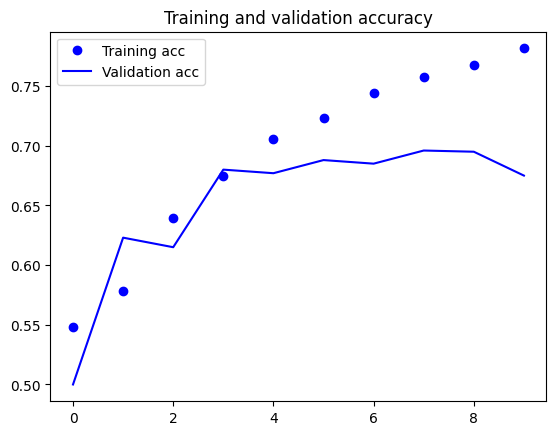

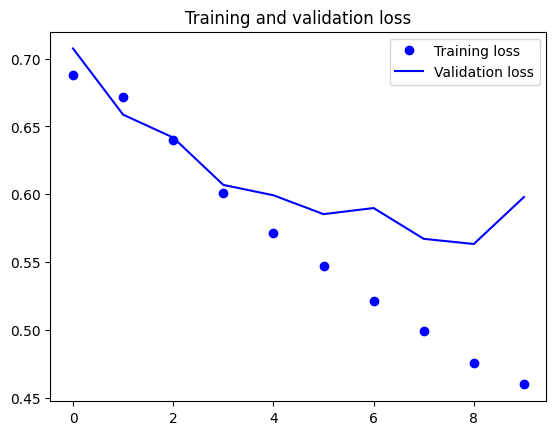

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 이 그래프는 과대적합(overfitting)의 특성을 보여줌
- 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달함  
반면 검증 정확도는 70-72%에서 멈춤  
<font color="blue">**즉, 학습 정확도와 검증 정확도의 차이가 크게남 -->overfitting의 전형적인 특징임**</font>
- 검증 손실은 다섯 번의 에포크만에 최솟값에 다다른 이후에 더 이상 진전되지 않음.  
- 반면 훈련 손실은 거의 0에 도달할 때까지 선형적으로 계속 감소함

- 비교적 훈련 샘플의 수(2,000개)가 적기 때문에 과대적합이 가장 중요한 문제임
- **드롭아웃이나 가중치 감소(L2 규제)와 같은 과대적합을 감소시킬 수 있는 여러 가지 기법들을 배웠음**
- 여기에서는 컴퓨터 비전에 특화되어 있어서  
딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 새로운 방법인  
 <font color="blue"> **데이터 증식(Data augmentation)**</font>을 시도해 보겠음

## 데이터 증식 사용하기

- 과대적합은 학습할 샘플이 너무 적어 새로운 데이터에 일반화할 수 있는 모델을 훈련시킬 수 없기 때문에 발생함.
- **무한히 많은 데이터가 주어지면 데이터 분포의 모든 가능한 측면을 모델이 학습할 수 있을 것임**
- 데이터 증식은 기존의 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법임
- **이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘림**
- **훈련 시에 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표임**
- 모델이 데이터의 여러 측면을 학습하면 **일반화**에 도움이 될 것임

- 케라스에서는 `ImageDataGenerator`가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있음.   

예제를 먼저 만들어 보죠:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

추가적인 매개변수가 몇 개 더 있음 (케라스 문서를 참고).  
이 코드를 간단히 살펴보죠.

* `rotation_range`는 랜덤하게 사진을 회전시킬 각도 범위(0-180 사이).
* `width_shift_range`와 `height_shift_range`는 사진을 수평과 수직으로 랜덤하게 평행 이동시킬 범위 (전체 넓이와 높이에 대한 비율).
* `shear_range`는 랜덤하게 전단 변환(shearing transformations)을 적용할 각도 범위
* `zoom_range`는 랜덤하게 사진을 확대할 범위
* `horizontal_flip`은 랜덤하게 이미지를 수평으로 뒤집음. 수평 대칭을 가정할 수 있을 때 사용함 (예를 들어, 풍경/인물 사진).
* `fill_mode`는 회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략임.

증식된 이미지 샘플을 살펴보죠:

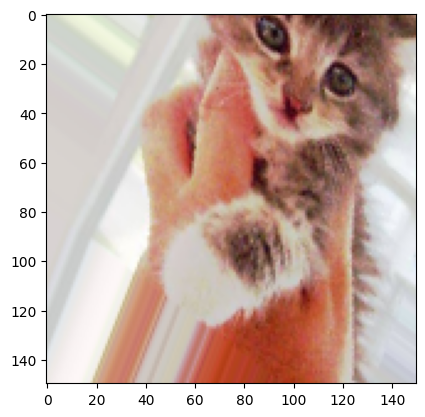

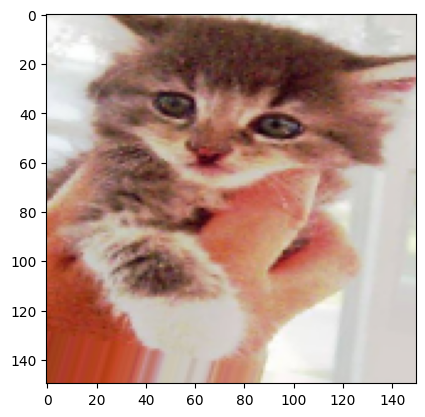

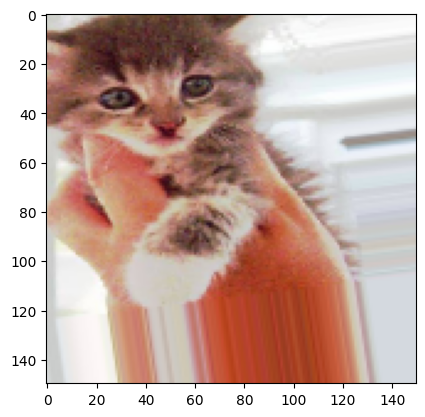

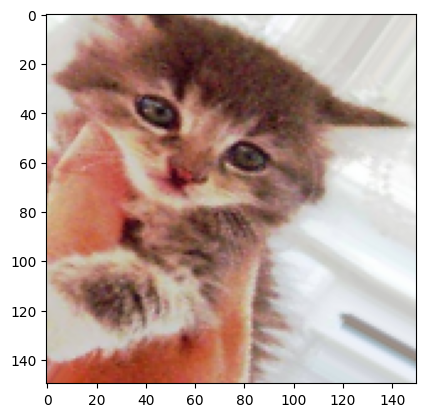

In [ ]:
# 이미지 전처리 유틸리티 모듈
from tensorflow.keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

- **데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않음**  
- **하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큼**
- 즉, 새로운 정보를 만들어낼 수 없고 단지 기존 정보의 재조합만 가능함.  
그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있음.
- 과대적합을 더 억제하기 위해 완전 연결 분류기 직전에 `Dropout` 층을 추가하겠음:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


데이터 증식과 드롭아웃을 사용하여 이 네트워크를 훈련시켜 봅시다:  
<font color="red">**주의: 일반적으로 검증 데이터와 테스트 데이터는 증식하지 않음**</font>

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - acc: 0.4988 - loss: 0.7009 - val_acc: 0.4950 - val_loss: 0.6930
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - acc: 0.5379 - loss: 0.6920 - val_acc: 0.5330 - val_loss: 0.6887
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - acc: 0.5520 - loss: 0.6885 - val_acc: 0.5450 - val_loss: 0.6771
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - acc: 0.5498 - loss: 0.6843 - val_acc: 0.5940 - val_loss: 0.6635
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - acc: 0.5701 - loss: 0.6713 - val_acc: 0.5760 - val_loss: 0.6727
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - acc: 0.5858 - loss: 0.6702 - val_acc: 0.5290 - val_loss: 0.7003
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - acc: 0.5781 - loss: 0.6740 - val_acc: 0.6140 - val_loss: 0.6493
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - acc: 0.6024 - loss: 0.6598 - val_acc: 0.6110 - val_loss: 0.6453
Epoch 9/100
100/100 ━━━━

다음 절에서 이 모델을 사용하기 위해 모델을 저장합니다.

In [ ]:
model.save('cats_and_dogs_small_2.keras')

In [ ]:
# # 참고로 저장한 모델을 불러와서 사용하려면:
# from tensorflow.keras.models import load_model
# model = load_model('cats_and_dogs_small_2.keras')

결과 그래프를 다시 그려 보죠:

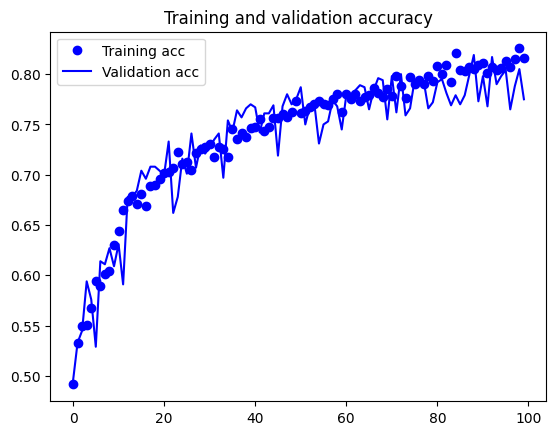

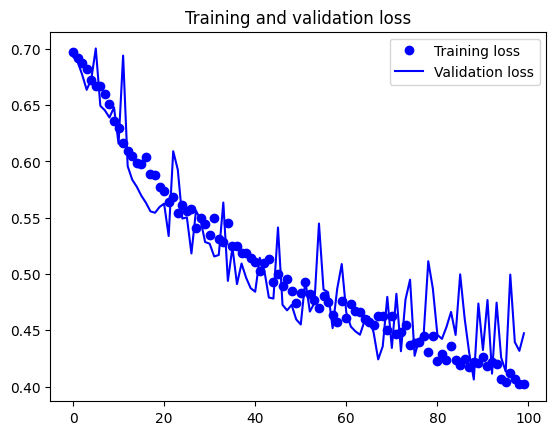

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

Found 1000 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - acc: 0.7964 - loss: 0.4378
Test Accuracy: 0.7820000052452087
Test Loss: 0.4666197597980499


- 그림 5-12와 5-13을 참고하세요.
- <span style="color:purple">**데이터 증식(data augmentation)과 드롭아웃(dropout)**</span> 덕택에 더이상 과대적합되지 않음
- 훈련 곡선이 검증 곡선에 가깝게 따라가고 있음
- 검증 데이터에서 82% 정확도를 달성함. 규제하지 않은 모델과 비교했을 때 15% 정도 향상됨
- (하지만 여전히 테스트 데이터에서는 78%의 정확도)

- 다른 규제 기법을 더 사용하고 네트워크의 파라미터를 튜닝하면(합성곱 층의 필터 수나 네트워크의 층의 수 등) 86%나 87% 정도까지 더 높은 정확도를 얻을 수도 있음
- 하지만 데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어려움 (원천적인 한계)
- 이런 상황에서 정확도를 높이기 위한 다음 단계는 <font color="blue"><U>**사전 훈련된 모델(pretrained model)**</U></font>을 사용하는 것임.

다음 두 절에서 이에 대해 집중적으로 살펴보겠습니다.